In [1]:
#Importing the NBAStats Package

#Inherited from NBAStats API, created by Bradley Fray. 
# Modified by Lucas, adding more classes for the original API to enrich its returned data for analysis purpose. 
# Such as PlayerBio, PlayerStats, Team, etc. 
# 	* The data returned by the API is transformed into pandas dataframe

import nbastats.nbastats as nba

/Users/Lucas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pytz/__init__.py:29: UserWarning: Module argparse was already imported from /Users/Lucas/anaconda/lib/python2.7/argparse.pyc, but /Users/Lucas/anaconda/lib/python2.7/site-packages is being added to sys.path
  from pkg_resources import resource_stream


In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn.metrics as metrics
import sklearn.utils as utils
import sklearn.linear_model as linear_model
import sklearn.cross_validation as cross_validation
import seaborn as sns
import scipy as sp
import scipy.sparse.linalg as linalg
import scipy.cluster.hierarchy as hr
from sklearn.preprocessing import StandardScaler as std_sca
from sklearn.cluster import KMeans
from patsy import dmatrices

print 'successfuly imported packages'

successfuly imported packages


# Hypothesis

    1. What is the influence of height of player to his performance on Stats in NBA
            Such as is there a correlation bewteen height and free throw percentage 
        Intersting news: According to Murey, rockets general manager, 3 point has become more and more important on 
                           wining the game. Does it true?   Does it true?  
                                       
    2. Does winning games of a team always have the same behaviors? In other words, When a team wins different
        games, does it because the team has similiar behaviors on stats? 

# Analysis

Recall: Is there a correlation between height and free-throw percentage?

First, we are going to find 50 different players and their height and career free throw percentage using API we have
10 Point Guards, 10 Short Guards, 10 Small Forward, 10 Power Forward, 10 Centers, since in general, PG and SG are 
shorter than SF and PF. And SF and PF are shorter than C. It is a good way for us to classify different plays with their
heights. 

All players listed here are active player, which means they are not retired.

References: http://stats.nba.com/

50 different players ID:
    Point Guards:
            1. STEPHEN CURRY      201939
            2. KYRIE IRVING       202681
            3. RUSSELL WESTBROOK  201566
            4. MIKE CONLEY        201144
            5. DAMIAN LILLARD     203081
            6. CHRIS PAUL         101108
            7. JOHN WALL          202322
            8. DERRICK ROSE       201565
            9. JEREMY LIN         202391
            10. RAJON RONDO       200765
             
    Shooting Guards:
            1. JAMES HARDEN       201935
            2. GORDON HAYWARD     202330
            3. JAMAL CRAWFORD     2037
            4. DWYANE WADE        2548
            5. KOBE BRYANT        977
            6. JJ REDICK          200755
            7. BRADLEY BEAL       203078
            8. KLAY THOMPSON      202691
            9. KYLE KORVER        2594
            10. MONTA ELLIS       101145
            
    Power Forwards:
            1. ANTHONY DAVIS      203076
            2. LAMARCUS ALDRIDGE  200746
            3. BLAKE GRIFFIN      201933
            4. KEVIN LOVE         201567
            5. JOSH SMITH         2746
            6. TIM DUNCAN         1495
            7. DIRK NOWITZKI      1717
            8. BORIS DIAW         2564
            9. PAUL MILLSAP       200794
            10. LEBORN JAMES      2544
            
    Small Forwards:
            1. PAUL PIERCE        1718
            2. JIMMY BUTLER       202710
            3. KAWHI LEONARD      202695
            4. DANNY GREEN        201980
            5. CHANDLER PARSONS   202718
            6. MIKE DUNLEAVY      2399
            7. KEVIN DURANT       201142
            8. CARMELO ANTHONY    2546
            9. DRAYMOND GREEN     203110
            10. JOE JOHNSON       2207
            
    Centers:
            1. DEMARCUS COUSINS   202326
            2. ZACH RANDOLPH      2216
            3. GREG MONROE        202328
            4. TYSON CHANDLER     2199       
            5. AL JEFFERSON       2744
            6. MARC GASOL         201188
            7. JOAKIM NOAH        201149              
            8. DWIGHT HOWARD      2730
            9. PAU GASOL          2200
            10. DEANDRE JORDON    201599
            

In [3]:
#Sample API output
curry = nba.PlayerBio('201939')
curry.bio()

,PERSON_ID,FIRST_NAME,LAST_NAME,DISPLAY_FIRST_LAST,DISPLAY_LAST_COMMA_FIRST,DISPLAY_FI_LAST,BIRTHDATE,SCHOOL,COUNTRY,LAST_AFFILIATION,HEIGHT,WEIGHT,SEASON_EXP,JERSEY,POSITION,ROSTERSTATUS,TEAM_ID,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CODE,TEAM_CITY,PLAYERCODE,FROM_YEAR,TO_YEAR,DLEAGUE_FLAG
0,201939,Stephen,Curry,Stephen Curry,"Curry, Stephen",S. Curry,1988-03-14T00:00:00,Davidson,USA,Davidson/USA,6-3,190,5,30,Guard,Active,1610612744,Warriors,GSW,warriors,Golden State,stephen_curry,2009,2014,N


In [4]:
curry  = nba.PlayerStats('201939')
curry.careerstats()

,PLAYER_ID,LEAGUE_ID,TEAM_ID,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,201939,00,0,416,410,35,7.5,15.9,0.471,2.9,6.5,0.44,3.1,3.5,0.9,0.7,3.5,4.1,6.9,1.7,0.2,3.2,2.6,20.9


In [5]:
# This will take a while to load the data. Thanks for your patient

PG =['201939','202681','201566','201144','203081','101108','202322','201565','202391','200765']
SG =['201935','202330','2037','2548','977','200755','203078','202691','2594','101145']
SF =['1718','202710','202695','201980','202718','2399','201142','2546','203110','2207']
PF =['203076','200746','201933','201567','2746','1495','1717','2564','200794','2544']
C =['202326','2216','202328','2199','2744','201188','201149','2730','2200','201599']

Players=[]
Players.extend(PG)
Players.extend(SG)
Players.extend(SF)
Players.extend(PF)
Players.extend(C)

columns = ['Heights', 'FT_PCT','FGM','FG3M','AST','REB','STL','BLK','TOV','PTS']
index = np.arange(50) # array of numbers for the number of samples
playerStat = pd.DataFrame(columns=columns, index = index)
h     = []
f     = []
fgm   = []
fg3m  = []
ast   = []
reb   = []
stl   = []
blk   = []
tov   = []
pts   = []

for i in range (0,50):
    for id_num in Players:
        
        bio = nba.PlayerBio(id_num)
        careerStats  = nba.PlayerStats(id_num)
        h.append(bio.bio()['HEIGHT'][0])
        f.append(careerStats.careerstats()['FT_PCT'][0])
        fgm.append(careerStats.careerstats()['FGM'][0])
        fg3m.append(careerStats.careerstats()['FG3M'][0])
        ast.append(careerStats.careerstats()['AST'][0])
        reb.append(careerStats.careerstats()['REB'][0])
        stl.append(careerStats.careerstats()['STL'][0])
        blk.append(careerStats.careerstats()['BLK'][0])
        tov.append(careerStats.careerstats()['TOV'][0])
        pts.append(careerStats.careerstats()['PTS'][0])
    
    playerStat.iloc[i,0] = str(h[i])
    playerStat.iloc[i,1] = str(f[i])
    playerStat.iloc[i,2] = str(fgm[i])
    playerStat.iloc[i,3] = str(fg3m[i])
    playerStat.iloc[i,4] = str(ast[i])
    playerStat.iloc[i,5] = str(reb[i])
    playerStat.iloc[i,6] = str(stl[i])
    playerStat.iloc[i,7] = str(blk[i])
    playerStat.iloc[i,8] = str(tov[i])
    playerStat.iloc[i,9] = str(pts[i])
    

playerStat

,Heights,FT_PCT,FGM,FG3M,AST,REB,STL,BLK,TOV,PTS
0,6-3,0.9,7.5,2.9,6.9,4.1,1.7,0.2,3.2,20.9
1,6-3,0.862,7.6,1.8,5.7,3.5,1.4,0.3,2.8,21.0
2,6-3,0.819,7.4,0.8,7.1,5.2,1.7,0.3,3.6,21.1
3,6-1,0.803,4.9,1.1,5.6,2.9,1.5,0.2,2.1,13.4
4,6-3,0.861,6.9,2.4,6.1,3.8,1.0,0.3,2.7,20.2
5,6-0,0.861,6.6,1.1,9.9,4.4,2.4,0.1,2.4,18.7
6,6-4,0.789,6.4,0.6,8.7,4.4,1.7,0.6,3.7,17.6
7,6-3,0.815,7.8,0.9,6.5,3.7,0.8,0.4,3.0,20.4
8,6-3,0.799,4.0,0.9,4.8,2.6,1.3,0.4,2.5,11.7
9,6-1,0.609,4.5,0.2,8.3,4.7,1.8,0.1,2.8,10.8


In [6]:
for idx, row in playerStat.iterrows():
    if idx < 10:
        playerStat.ix[idx,'position']='1'
    elif idx < 20:
        playerStat.ix[idx,'position']='2'
    elif  idx < 30:
        playerStat.ix[idx,'position']='3'
    elif idx < 40:
        playerStat.ix[idx,'position']='4'
    else:
        playerStat.ix[idx,'position']='5'
        
playerStat

,Heights,FT_PCT,FGM,FG3M,AST,REB,STL,BLK,TOV,PTS,position
0,6-3,0.9,7.5,2.9,6.9,4.1,1.7,0.2,3.2,20.9,1
1,6-3,0.862,7.6,1.8,5.7,3.5,1.4,0.3,2.8,21.0,1
2,6-3,0.819,7.4,0.8,7.1,5.2,1.7,0.3,3.6,21.1,1
3,6-1,0.803,4.9,1.1,5.6,2.9,1.5,0.2,2.1,13.4,1
4,6-3,0.861,6.9,2.4,6.1,3.8,1.0,0.3,2.7,20.2,1
5,6-0,0.861,6.6,1.1,9.9,4.4,2.4,0.1,2.4,18.7,1
6,6-4,0.789,6.4,0.6,8.7,4.4,1.7,0.6,3.7,17.6,1
7,6-3,0.815,7.8,0.9,6.5,3.7,0.8,0.4,3.0,20.4,1
8,6-3,0.799,4.0,0.9,4.8,2.6,1.3,0.4,2.5,11.7,1
9,6-1,0.609,4.5,0.2,8.3,4.7,1.8,0.1,2.8,10.8,1


In [7]:
# It is difficult to compare players' heights when the height is in units as feet and inch. 
# So this method transfer units from feel to inches and it is easy for us to compare.
def parse_height(str):
  feet_inches = str.split("'")
  if len(feet_inches) != 2:
    raise ValueError("invalid literal for parse_height: " + str)
  return 12 * int(feet_inches[0]) + float(feet_inches[1])

parse_height('6\'3')

75.0

In [8]:
# heights_freethrows.info()
playerStat['HeightsNum'] = playerStat['Heights'].str.replace('-', '\'')
playerStat["HeightsNum"] = playerStat["HeightsNum"].apply(lambda x:parse_height(x))

playerStat = playerStat.convert_objects(convert_numeric=True)
playerStat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 12 columns):
Heights       50 non-null object
FT_PCT        50 non-null float64
FGM           50 non-null float64
FG3M          50 non-null float64
AST           50 non-null float64
REB           50 non-null float64
STL           50 non-null float64
BLK           50 non-null float64
TOV           50 non-null float64
PTS           50 non-null float64
position      50 non-null int64
HeightsNum    50 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.1+ KB


In [9]:
player_pairs = playerStat.convert_objects(convert_numeric=True)
player_pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 12 columns):
Heights       50 non-null object
FT_PCT        50 non-null float64
FGM           50 non-null float64
FG3M          50 non-null float64
AST           50 non-null float64
REB           50 non-null float64
STL           50 non-null float64
BLK           50 non-null float64
TOV           50 non-null float64
PTS           50 non-null float64
position      50 non-null int64
HeightsNum    50 non-null float64
dtypes: float64(10), int64(1), object(1)
memory usage: 5.1+ KB


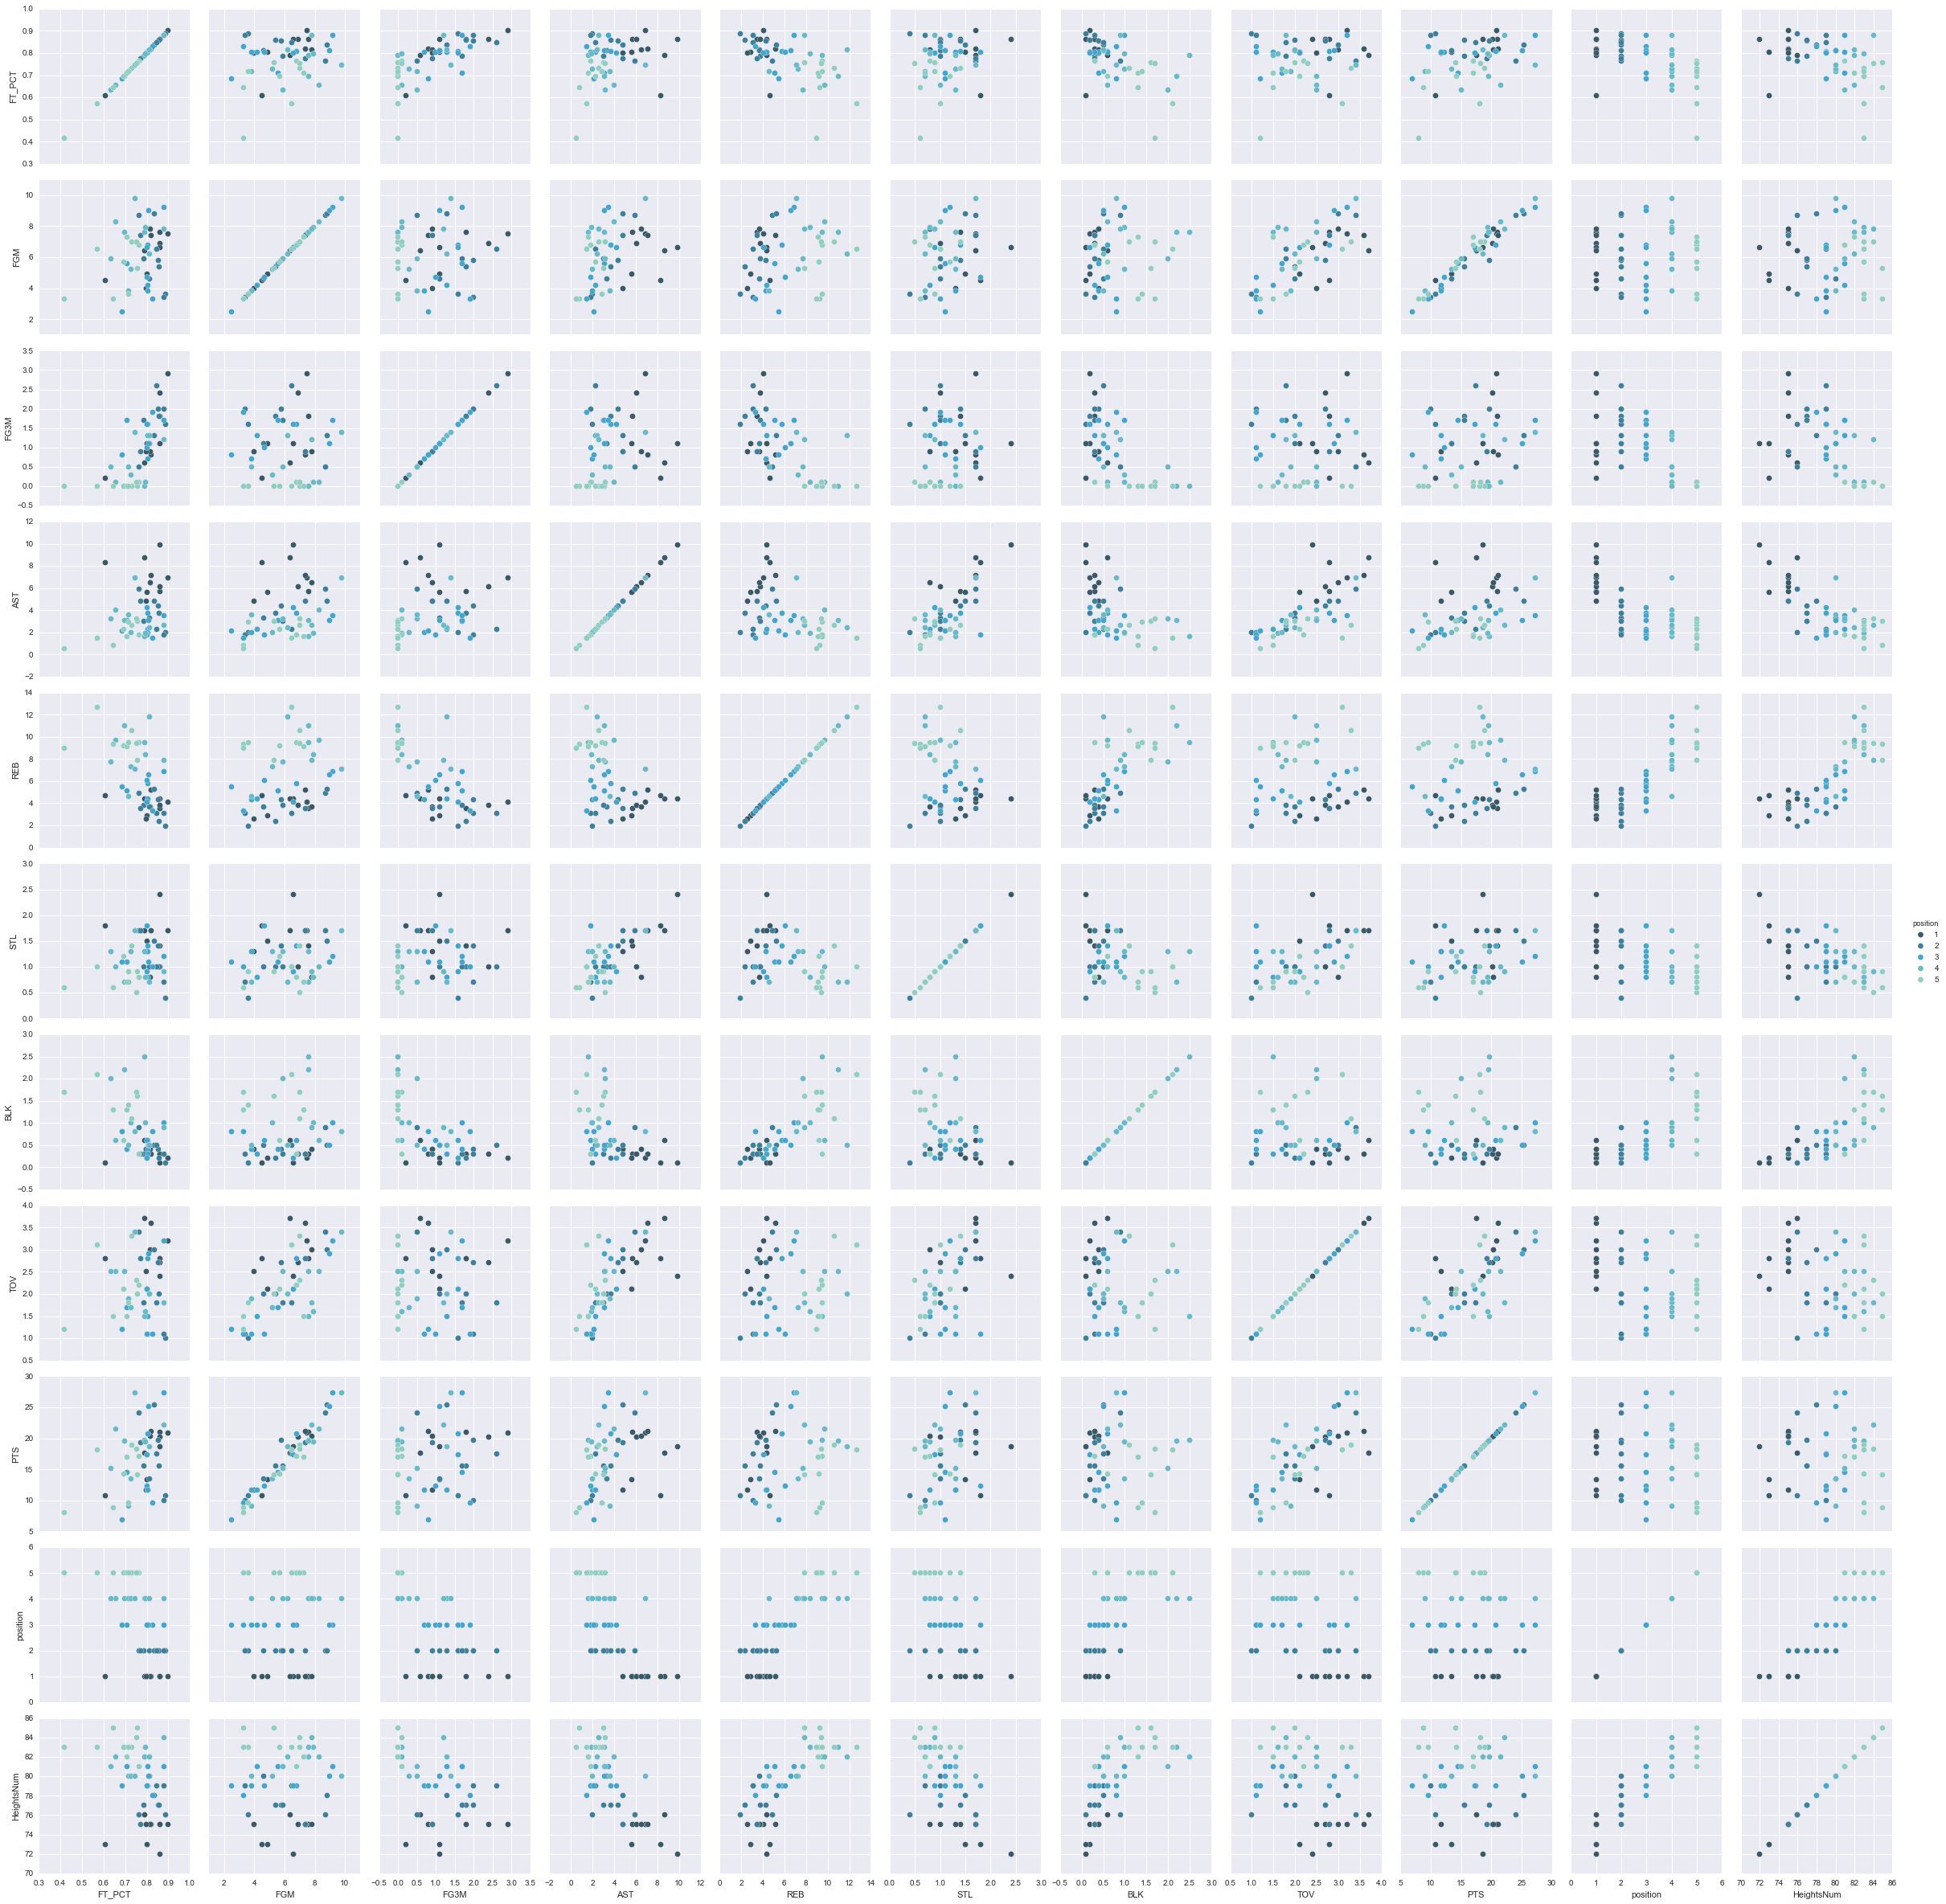

In [10]:
g1 = sns.PairGrid(player_pairs, hue ='position',palette="GnBu_d")
g1.map(plt.scatter, s=50, edgecolor="white")
g1.add_legend()

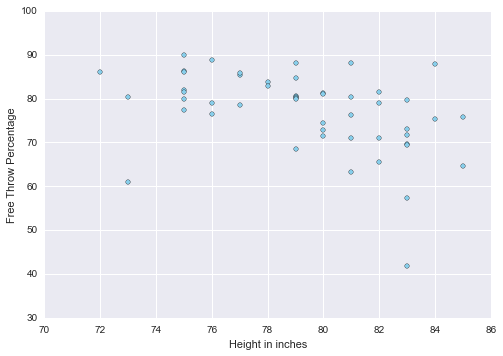

In [13]:
X = playerStat['HeightsNum']
y = playerStat['FT_PCT'] *100


plt.scatter(X, y, c="skyblue")
plt.xlabel('Height in inches')
plt.ylabel('Free Throw Percentage')

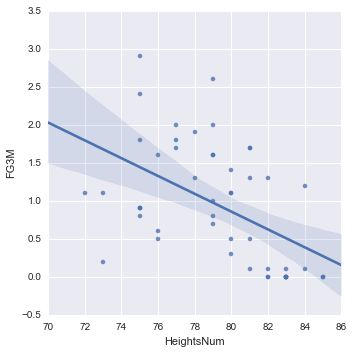

In [15]:
# Fit a line for the data we analyze 
sns.lmplot("HeightsNum", "FG3M", playerStat);

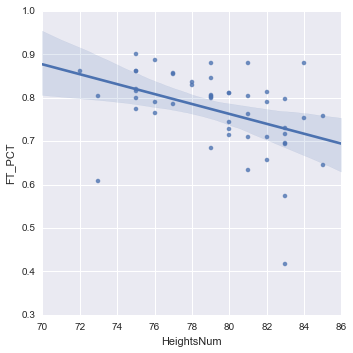

In [16]:
# Fit a line for the data we analyze 
sns.lmplot("HeightsNum", "FT_PCT", playerStat);

In [10]:
model = sm.OLS(y, X)
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params

                            OLS Regression Results                            
Dep. Variable:                 FT_PCT   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2448.
Date:                Tue, 28 Apr 2015   Prob (F-statistic):           1.71e-43
Time:                        13:36:38   Log-Likelihood:                -190.29
No. Observations:                  50   AIC:                             382.6
Df Residuals:                      49   BIC:                             384.5
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
HeightsNum     0.9692      0.020     49.474      0.000         0.930     1.009
Omnibus:                       13.267   Durbin-Watso

In [11]:
X, y = utils.shuffle(playerStat['HeightsNum'], playerStat['FT_PCT'] *100, random_state=1)

In [12]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape), y_train.shape
print(X_test.shape), y_test.shape

(45,) (45,)
(5,) (5,)


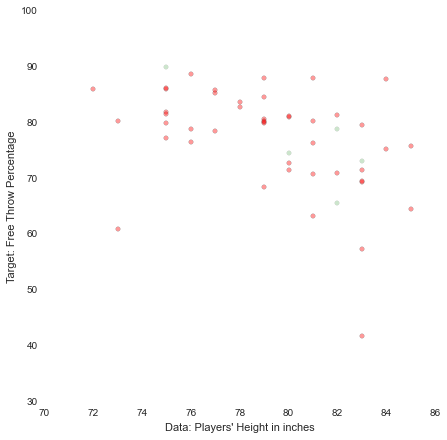

In [13]:
fig, axes = plt.subplots(figsize=(7,7))
subX_train = X_train
subX_test = X_test
plt.scatter(subX_train, y_train, c="red", alpha=0.4, linewidths=0.3)
plt.scatter(subX_test, y_test, c="green", alpha=0.2, linewidths=0.3)
plt.xlabel('Data: Players\' Height in inches')
plt.ylabel('Target: Free Throw Percentage');

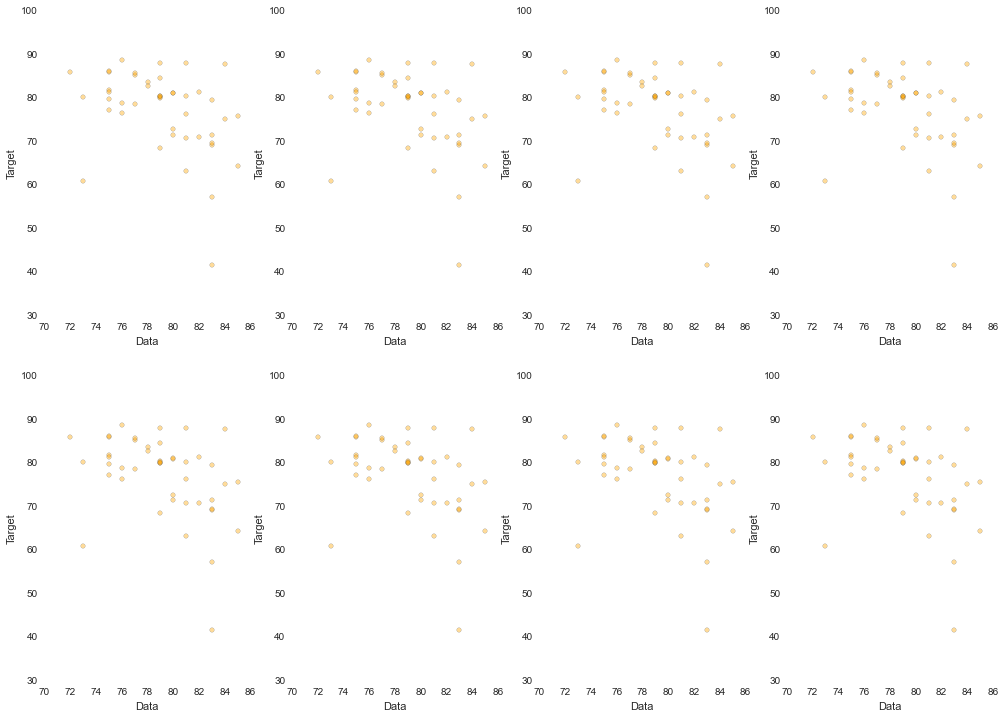

In [14]:
fig, axes = plt.subplots(2,4,figsize=(17,12))

for i in range(8):
    plt_i = i // 4
    plt_j = i % 4
    subX_train = X_train
    # plt.subplot(2, 4, 1 + i)
    axes[plt_i][plt_j].scatter(subX_train, y_train, c="orange", alpha=0.4, linewidths=0.3)
    #plt.scatter(subX_test, y_test)
    axes[plt_i][plt_j].set_xlabel('Data')
    axes[plt_i][plt_j].set_ylabel('Target'); 

In [15]:
regr = linear_model.LinearRegression()
regr.fit(X_train[:,np.newaxis], y_train);

# X_train[:,np.newaxis]
# y_train

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

In [16]:
# The mean square error
print len(X_train)
print len(X_test)

print("Training error: ", metrics.mean_squared_error(regr.predict(X_train[:,np.newaxis]),y_train)/len(X_train))
print("Test     error: ", metrics.mean_squared_error(regr.predict(X_test[:,np.newaxis]),y_test)/len(X_test))

45
5
('Training error: ', 1.5919113341120319)
('Test     error: ', 6.7984959044074369)


In [17]:
# Training and Testing Score
train_score = regr.score(X_train[:,np.newaxis][:,np.newaxis],y_train)
test_score = regr.score(X_test[:,np.newaxis],y_test)
print("Training score: ", train_score)
print("Test     score: ", test_score)

('Training score: ', 0.15237903284714072)
('Test     score: ', 0.47273630483146845)


Recall: Hypothesis 2: Does three-point actually help teams win the game?
        
        For this hypothesis, we found 10 different teams in NBA, 5 teams in each conference (West,East), and all 
        of these 10 teams are competitive in the past 5 years and most of them has not missed the playoff games 
        recently. 
        
                  Team                        Team ID
        
East     
            1. ATLANTA HAWKS                1610612737
            2. CHICAGO BULLS                1610612741
            3. CLEVELAND CAVALIERS          1610612739 
            4. MIAMI HEAT                   1610612748
            5. WASHINGTON WIZARDS           1610612764 

West     
            1. GOLDEN STATE WARRIORS        1610612744
            2. HOUSTON ROCKETS              1610612745
            3. SAN ANTONIO SPURS            1610612759
            4. DALLAS MAVERICKS             1610612742
            5. LOS ANGELES CLIPPERS         1610612746 
 





In [18]:
# API returns names of teams. 
spurs = nba.Team_info('1610612759', season='2014-15')
spurs.info()


,TEAM_ID,SEASON_YEAR,TEAM_CITY,TEAM_NAME,TEAM_ABBREVIATION,TEAM_CONFERENCE,TEAM_DIVISION,TEAM_CODE,W,L,PCT,CONF_RANK,DIV_RANK,MIN_YEAR,MAX_YEAR
0,1610612759,2014-15,San Antonio,Spurs,SAS,West,Southwest,spurs,55,27,0.671,6,3,1976,2014


In [19]:
spurs = nba.Team_details('1610612759', season='2014-15')
spurs.overall()

,GROUP_SET,GROUP_VALUE,SEASON_YEAR,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS
0,Overall,2014-15,2014-15,82,55,27,0.671,48.7,39.1,83.6,0.468,8.3,22.5,0.367,16.7,21.4,0.78,9.8,33.8,43.6,24.4,14,8,5.4,4.4,19.1,19.7,103.2,6.2,155,2014-15


In [20]:
# This would also take a while to process. Thanks for your patient! 

West =['1610612744','1610612745','1610612759','1610612742','1610612746']
East= ['1610612737','1610612741','1610612739','1610612748','1610612764']
        
Teams = []
Teams.extend(West)
Teams.extend(East)
Seasons = ['2010-11','2011-12','2012-13','2013-14','2014-15']

    
columns = ['TEAM_NAME','SEASON_YEAR','W_PCT','FG3M','FG3A']
index = np.arange(50) # array of numbers for the number of samples
win_3pts = pd.DataFrame(columns=columns, index = index)

n = []
s = []
w = []
m = []
a = []

for i in range (0,50):
    for id_num in Teams:
        for season in Seasons:
            name = nba.Team_info(id_num, season=season)
            team = nba.Team_details(id_num, season=season)
            n.append(name.info()['TEAM_NAME'][0])
            s.append(team.overall()['SEASON_YEAR'][0])
            w.append(team.overall()['W_PCT'][0])
            m.append(team.overall()['FG3M'][0])
            a.append(team.overall()['FG3A'][0])
            
    win_3pts.iloc[i,0] = str(n[i]) 
    win_3pts.iloc[i,1] = str(s[i])        
    win_3pts.iloc[i,2] = str(w[i])
    win_3pts.iloc[i,3] = str(m[i])
    win_3pts.iloc[i,4] = str(a[i])
    
win_3pts  
    


,TEAM_NAME,SEASON_YEAR,W_PCT,FG3M,FG3A
0,Warriors,2010-11,0.439,8.4,21.3
1,Warriors,2011-12,0.348,7.9,20.5
2,Warriors,2012-13,0.573,8.0,19.9
3,Warriors,2013-14,0.622,9.4,24.8
4,Warriors,2014-15,0.817,10.8,27.0
5,Rockets,2010-11,0.524,8.3,22.5
6,Rockets,2011-12,0.515,7.2,20.2
7,Rockets,2012-13,0.549,10.6,28.9
8,Rockets,2013-14,0.659,9.5,26.6
9,Rockets,2014-15,0.683,11.4,32.7


In [22]:
#Dividing dataframe into 10 different ones for anaylysis
Warriors  = win_3pts [0:5]
Rockets   = win_3pts [5:10]
Spurs     = win_3pts [10:15]
Mavericks = win_3pts [15:20]
Clippers  = win_3pts [20:25]

Hawks     = win_3pts [25:30]
Bulls     = win_3pts [30:35]
Cavaliers = win_3pts [35:40]
Heat      = win_3pts [40:45]
Wizards   = win_3pts [45:50]


In [53]:
win_3pts.info()
pairs = win_3pts.convert_objects(convert_numeric=True)
pairs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 5 columns):
TEAM_NAME      50 non-null object
SEASON_YEAR    50 non-null object
W_PCT          50 non-null object
FG3M           50 non-null object
FG3A           50 non-null object
dtypes: object(5)
memory usage: 2.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 5 columns):
TEAM_NAME      50 non-null object
SEASON_YEAR    50 non-null object
W_PCT          50 non-null float64
FG3M           50 non-null float64
FG3A           50 non-null float64
dtypes: float64(3), object(2)
memory usage: 2.3+ KB


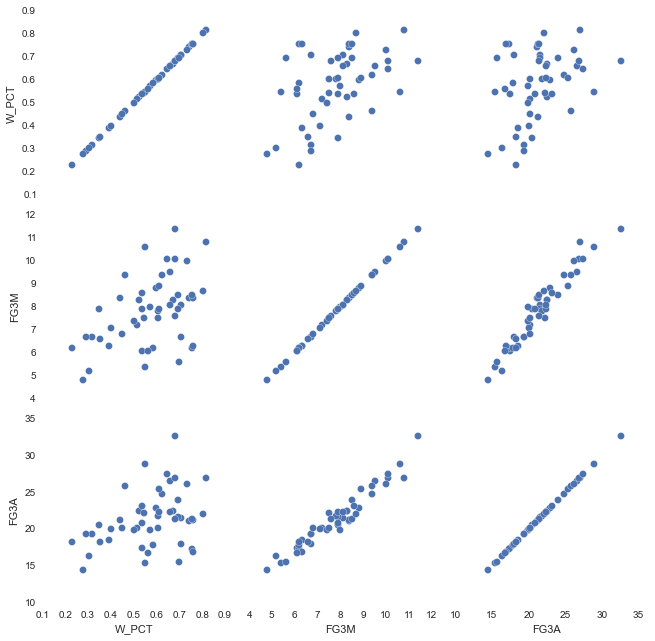

In [55]:
g = sns.PairGrid(pairs, palette="GnBu_d")
g.map(plt.scatter, s=50, edgecolor="white")
g.add_legend()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


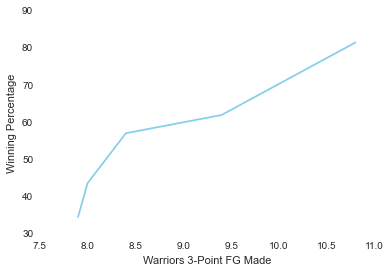

In [23]:
Warriors = Warriors.convert_objects(convert_numeric=True)
Warriors.info()
X = sorted(Warriors['FG3M'])
y = sorted(Warriors['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Warriors 3-Point FG Made')
plt.ylabel('Winning Percentage')


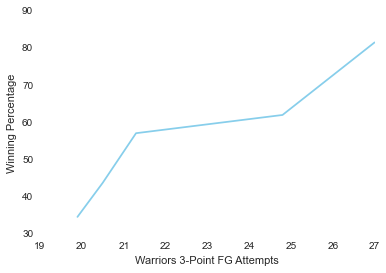

In [24]:
X = sorted(Warriors['FG3A'])
y = sorted(Warriors['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Warriors 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 5 to 9
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


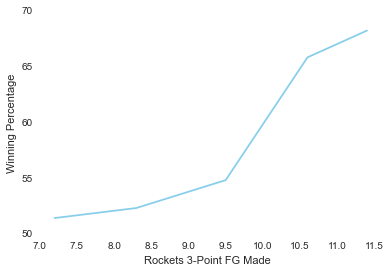

In [25]:
Rockets = Rockets.convert_objects(convert_numeric=True)
Rockets.info()
X = sorted(Rockets['FG3M'])
y = sorted(Rockets['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Rockets 3-Point FG Made')
plt.ylabel('Winning Percentage')

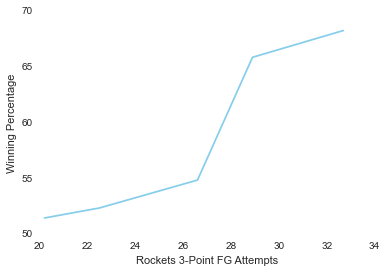

In [26]:
X = sorted(Rockets['FG3A'])
y = sorted(Rockets['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Rockets 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 10 to 14
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


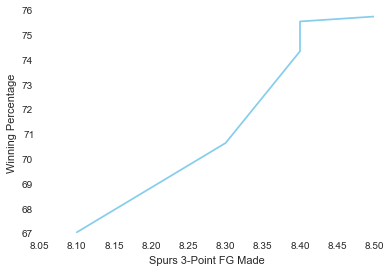

In [27]:
Spurs = Spurs.convert_objects(convert_numeric=True)
Spurs.info()
X = sorted(Spurs['FG3M'])
y = sorted(Spurs['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Spurs 3-Point FG Made')
plt.ylabel('Winning Percentage')

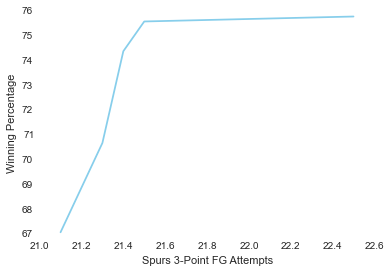

In [28]:
X = sorted(Spurs['FG3A'])
y = sorted(Spurs['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Spurs 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 15 to 19
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


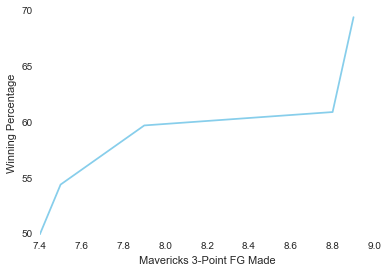

In [29]:
Mavericks = Mavericks.convert_objects(convert_numeric=True)
Mavericks.info()
X = sorted(Mavericks['FG3M'])
y = sorted(Mavericks['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Mavericks 3-Point FG Made')
plt.ylabel('Winning Percentage')

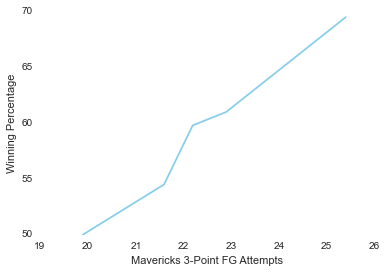

In [30]:
X = sorted(Mavericks['FG3A'])
y = sorted(Mavericks['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Mavericks 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 20 to 24
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


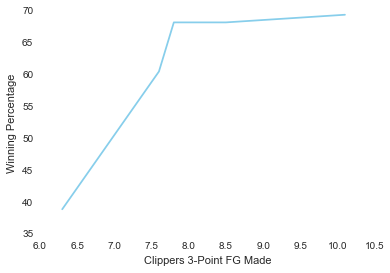

In [31]:
Clippers = Clippers.convert_objects(convert_numeric=True)
Clippers.info()
X = sorted(Clippers['FG3M'])
y = sorted(Clippers['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Clippers 3-Point FG Made')
plt.ylabel('Winning Percentage')

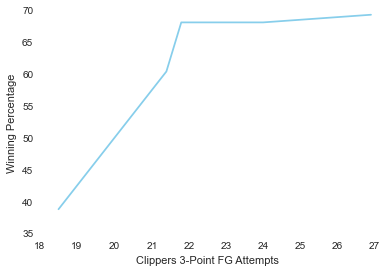

In [32]:
X = sorted(Clippers['FG3A'])
y = sorted(Clippers['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Clippers 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 25 to 29
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


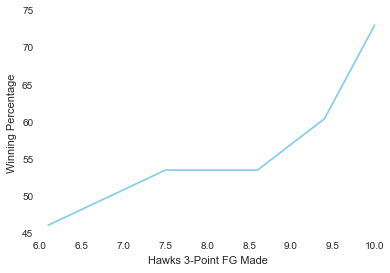

In [33]:
Hawks = Hawks.convert_objects(convert_numeric=True)
Hawks.info()
X = sorted(Hawks['FG3M'])
y = sorted(Hawks['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Hawks 3-Point FG Made')
plt.ylabel('Winning Percentage')

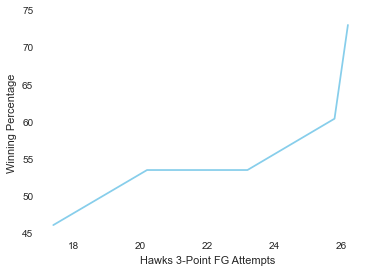

In [34]:
X = sorted(Hawks['FG3A'])
y = sorted(Hawks['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Hawks 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 30 to 34
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


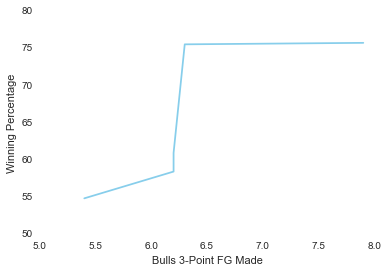

In [35]:
Bulls = Bulls.convert_objects(convert_numeric=True)
Bulls.info()
X = sorted(Bulls['FG3M'])
y = sorted(Bulls['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Bulls 3-Point FG Made')
plt.ylabel('Winning Percentage')

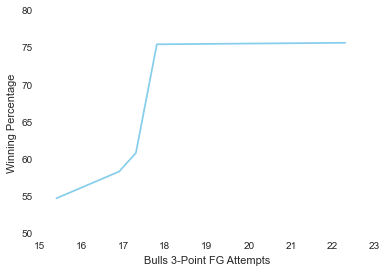

In [36]:
X = sorted(Bulls['FG3A'])
y = sorted(Bulls['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Bulls 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 35 to 39
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


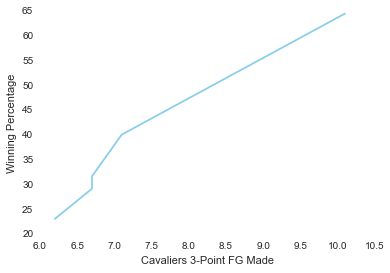

In [37]:
Cavaliers = Cavaliers.convert_objects(convert_numeric=True)
Cavaliers.info()
X = sorted(Cavaliers['FG3M'])
y = sorted(Cavaliers['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Cavaliers 3-Point FG Made')
plt.ylabel('Winning Percentage')

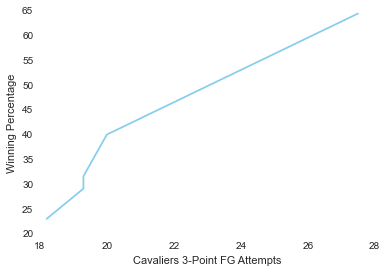

In [38]:
X = sorted(Cavaliers['FG3A'])
y = sorted(Cavaliers['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Cavaliers 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 40 to 44
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


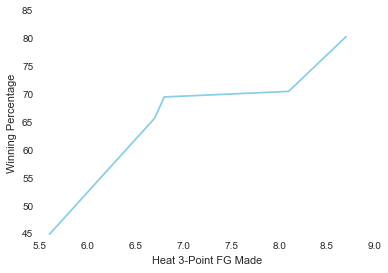

In [39]:
Heat = Heat.convert_objects(convert_numeric=True)
Heat.info()
X = sorted(Heat['FG3M'])
y = sorted(Heat['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Heat 3-Point FG Made')
plt.ylabel('Winning Percentage')

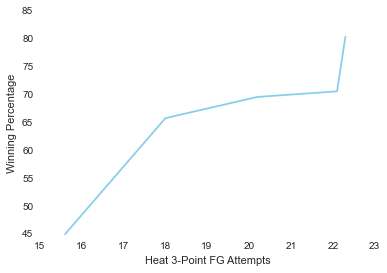

In [40]:
X = sorted(Heat['FG3A'])
y = sorted(Heat['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Heat 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 45 to 49
Data columns (total 5 columns):
TEAM_NAME      5 non-null object
SEASON_YEAR    5 non-null object
W_PCT          5 non-null float64
FG3M           5 non-null float64
FG3A           5 non-null float64
dtypes: float64(3), object(2)
memory usage: 240.0+ bytes


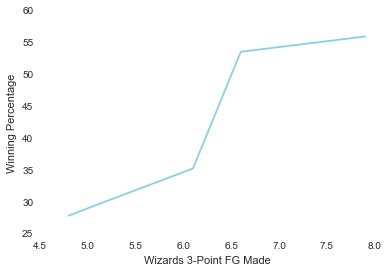

In [41]:
Wizards = Wizards.convert_objects(convert_numeric=True)
Wizards.info()
X = sorted(Wizards['FG3M'])
y = sorted(Wizards['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Wizards 3-Point FG Made')
plt.ylabel('Winning Percentage')

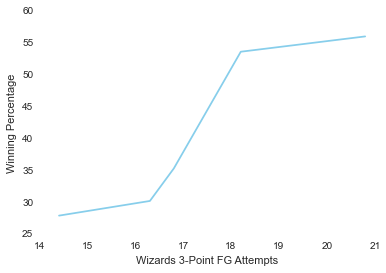

In [42]:
X = sorted(Wizards['FG3A'])
y = sorted(Wizards['W_PCT'] *100)

plt.plot(X, y, c="skyblue")
plt.xlabel('Wizards 3-Point FG Attempts')
plt.ylabel('Winning Percentage')

In [43]:
X = sorted(Spurs['FG3A'])
y = sorted(Spurs['W_PCT'] *100)


model = sm.OLS(y, X)
results = model.fit()
print results.summary()
print "Confidence Intervals:", results.conf_int()
print "Parameters:", results.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     3278.
Date:                Tue, 28 Apr 2015   Prob (F-statistic):           5.57e-07
Time:                        13:47:03   Log-Likelihood:                -11.758
No. Observations:                   5   AIC:                             25.52
Df Residuals:                       4   BIC:                             25.13
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             3.3736      0.059     57.254      0.000         3.210     3.537
Omnibus:                          nan   Durbin-Watso

In [3]:
SAS = nba.Team_Gamelog('1610612759', season = '2014-15')
GameLog = SAS.gamelog()
GameLog

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS
0,1610612759,0021401223,"APR 15, 2015",SAS @ NOP,L,240,45,79,0.570,3,10,0.300,10,13,0.769,4,32,36,33,2,3,15,20,103
1,1610612759,0021401200,"APR 12, 2015",SAS vs. PHX,W,240,35,69,0.507,8,19,0.421,29,34,0.853,6,37,43,22,7,6,15,22,107
2,1610612759,0021401181,"APR 10, 2015",SAS @ HOU,W,240,41,85,0.482,4,17,0.235,18,24,0.750,13,27,40,23,12,3,15,35,104
3,1610612759,0021401168,"APR 08, 2015",SAS vs. HOU,W,240,48,95,0.505,7,21,0.333,7,9,0.778,13,34,47,21,11,7,9,13,110
4,1610612759,0021401157,"APR 07, 2015",SAS @ OKC,W,240,47,89,0.528,10,24,0.417,9,13,0.692,12,34,46,27,7,7,15,20,113
5,1610612759,0021401150,"APR 05, 2015",SAS vs. GSW,W,240,44,83,0.530,7,21,0.333,12,15,0.800,6,41,47,27,8,4,12,13,107
6,1610612759,0021401134,"APR 03, 2015",SAS vs. DEN,W,240,47,85,0.553,14,34,0.412,15,17,0.882,14,31,45,33,11,8,18,15,123
7,1610612759,0021401113,"APR 01, 2015",SAS @ ORL,W,240,35,86,0.407,13,29,0.448,20,23,0.870,11,38,49,20,8,3,10,9,103
8,1610612759,0021401110,"MAR 31, 2015",SAS @ MIA,W,240,37,74,0.500,8,18,0.444,13,17,0.765,8,30,38,21,11,6,19,19,95
9,1610612759,0021401098,"MAR 29, 2015",SAS vs. MEM,W,240,42,83,0.506,4,17,0.235,15,18,0.833,10,38,48,25,9,6,8,15,103


In [25]:
for idx, row in logs.iterrows():
    if row.WL == 'W':
        logs.ix[idx,'WorL']='1'
    else:
        logs.ix[idx,'WorL']='0'
logs

,Team_ID,Game_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,WorL
0,1610612759,21401223,"APR 15, 2015",SAS @ NOP,L,240,45,79,0.570,3,10,0.300,10,13,0.769,4,32,36,33,2,3,15,20,103,0
1,1610612759,21401200,"APR 12, 2015",SAS vs. PHX,W,240,35,69,0.507,8,19,0.421,29,34,0.853,6,37,43,22,7,6,15,22,107,1
2,1610612759,21401181,"APR 10, 2015",SAS @ HOU,W,240,41,85,0.482,4,17,0.235,18,24,0.750,13,27,40,23,12,3,15,35,104,1
3,1610612759,21401168,"APR 08, 2015",SAS vs. HOU,W,240,48,95,0.505,7,21,0.333,7,9,0.778,13,34,47,21,11,7,9,13,110,1
4,1610612759,21401157,"APR 07, 2015",SAS @ OKC,W,240,47,89,0.528,10,24,0.417,9,13,0.692,12,34,46,27,7,7,15,20,113,1
5,1610612759,21401150,"APR 05, 2015",SAS vs. GSW,W,240,44,83,0.530,7,21,0.333,12,15,0.800,6,41,47,27,8,4,12,13,107,1
6,1610612759,21401134,"APR 03, 2015",SAS vs. DEN,W,240,47,85,0.553,14,34,0.412,15,17,0.882,14,31,45,33,11,8,18,15,123,1
7,1610612759,21401113,"APR 01, 2015",SAS @ ORL,W,240,35,86,0.407,13,29,0.448,20,23,0.870,11,38,49,20,8,3,10,9,103,1
8,1610612759,21401110,"MAR 31, 2015",SAS @ MIA,W,240,37,74,0.500,8,18,0.444,13,17,0.765,8,30,38,21,11,6,19,19,95,1
9,1610612759,21401098,"MAR 29, 2015",SAS vs. MEM,W,240,42,83,0.506,4,17,0.235,15,18,0.833,10,38,48,25,9,6,8,15,103,1


In [46]:
logs_new = logs.convert_objects(convert_numeric=True)
logs_new['WorL'] = logs_new['WorL'].astype(float)
logs_new['BLK'] = logs_new['BLK'].astype(float)
logs_new['AST'] = logs_new['AST'].astype(float)
logs_new['REB'] = logs_new['REB'].astype(float)
logs_new['STL'] = logs_new['STL'].astype(float)
logs_new['FG3M'] = logs_new['FG3M'].astype(float)
logs_new['PTS'] = logs_new['PTS'].astype(float)
logs_new['TOV'] = logs_new['TOV'].astype(float)
logs_new['FGM'] = logs_new['FGM'].astype(float)
logs_new['FTM'] = logs_new['FTM'].astype(float)

logs_new.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 82 entries, 0 to 81
Data columns (total 25 columns):
Team_ID      82 non-null int64
Game_ID      82 non-null int64
GAME_DATE    82 non-null object
MATCHUP      82 non-null object
WL           82 non-null object
MIN          82 non-null int64
FGM          82 non-null float64
FGA          82 non-null int64
FG_PCT       82 non-null float64
FG3M         82 non-null float64
FG3A         82 non-null int64
FG3_PCT      82 non-null float64
FTM          82 non-null float64
FTA          82 non-null int64
FT_PCT       82 non-null float64
OREB         82 non-null int64
DREB         82 non-null int64
REB          82 non-null float64
AST          82 non-null float64
STL          82 non-null float64
BLK          82 non-null float64
TOV          82 non-null float64
PF           82 non-null int64
PTS          82 non-null float64
WorL         82 non-null float64
dtypes: float64(13), int64(9), object(3)
memory usage: 16.7+ KB


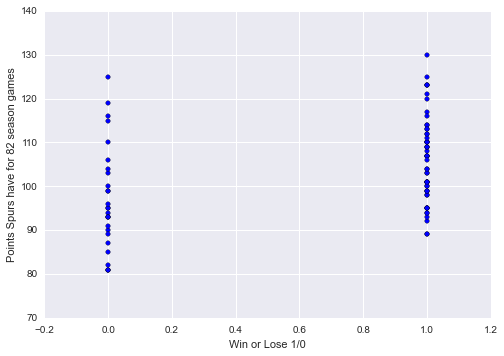

In [56]:
plt.scatter(logs_new['WorL'],logs_new['PTS'])
plt.xlabel('Win or Lose 1/0')
plt.ylabel('Points Spurs have for 82 season games')

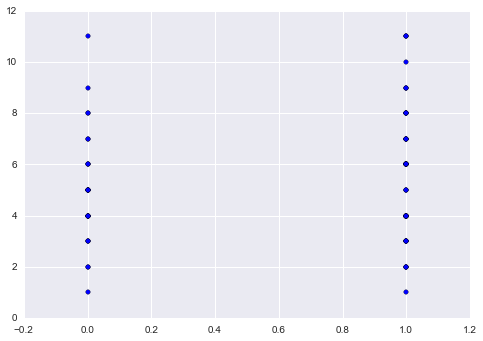

In [49]:
plt.scatter(logs_new['WorL'],logs_new['BLK'])

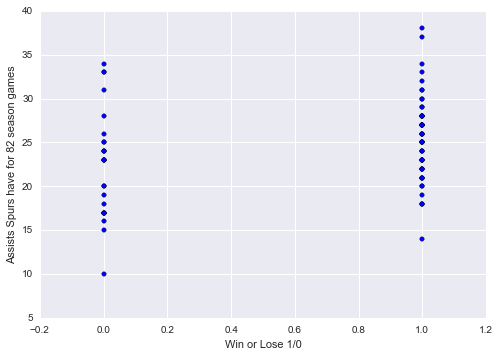

In [57]:
plt.scatter(logs_new['WorL'],logs_new['AST'])
plt.xlabel('Win or Lose 1/0')
plt.ylabel('Assists Spurs have for 82 season games')

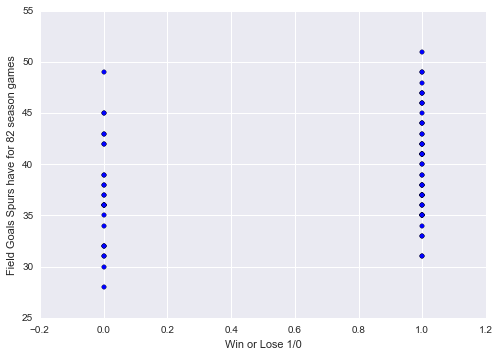

In [60]:
plt.scatter(logs_new['WorL'],logs_new['FGM'])
plt.xlabel('Win or Lose 1/0')
plt.ylabel('Field Goals Spurs have for 82 season games')

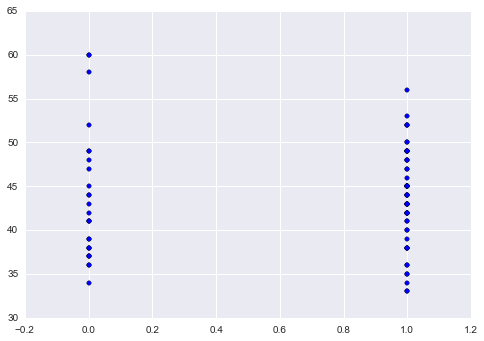

In [52]:
plt.scatter(logs_new['WorL'],logs_new['REB'])

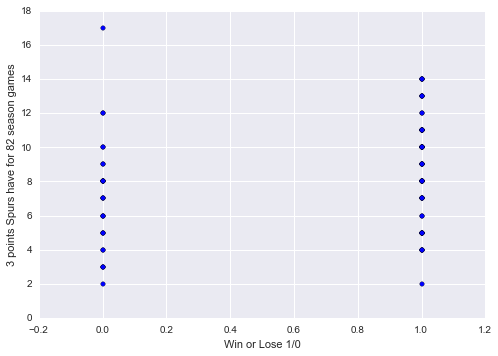

In [59]:
plt.scatter(logs_new['WorL'],logs_new['FG3M'])
plt.xlabel('Win or Lose 1/0')
plt.ylabel('3 points Spurs have for 82 season games')

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()